In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dir_name = '/kaggle/input/oil-gas-predict/oil_gas_train'
companies = []

for dirname, _, filenames in os.walk(dir_name):
    for filename in filenames:
        if filename != 'Книга8.xlsx':
            companies.append(filename.replace('.xlsx', ''))

companies.sort()
print(companies)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['AMPY', 'APA', 'AR', 'BATL', 'BCEI', 'BRY', 'BSM', 'CDEV', 'CHK', 'CLR', 'CNX', 'COG', 'COP', 'CPE', 'CRBO', 'CRC', 'CRK', 'DEN', 'DVN', 'EGY', 'EOG', 'EQT', 'ESTE', 'FANG', 'GDP', 'HES', 'LONE', 'LPI', 'MCF', 'MGY', 'MNRL', 'MRO', 'MTDR', 'MUR', 'NOG', 'OAS', 'OVV', 'PDCE', 'PVAC', 'PXD', 'REI', 'RRC', 'SBOW', 'SD', 'SM', 'SWN', 'TALO', 'TPL', 'VNOM', 'WLL', 'WTI', 'XEC', 'XOG']


Функция mapper преобразует имя компании в датафрейм, прочитанный из excel, так, чтобы данные начинались с Q1 '11 A. (У компании CRBO данные начинаются с Q1 '10 A).
В skiprows отбрасываем первые пустые строки и последние строки, начиная с Valuation.

In [3]:
def mapper(comp_name):
    if comp_name != 'CRBO':
        return pd.read_excel(dir_name + '/' + comp_name + '.xlsx', 
                             skiprows= lambda x: x < 27 or x >= 362, usecols='I:AU')
    else:
        return pd.read_excel(dir_name + '/' + comp_name + '.xlsx', 
                             skiprows= lambda x: x < 27 or x >= 362, usecols='I,N:AY')
dfs = list(map(mapper, companies))

dfs_dict - словарь, в котором по ключу-имени компании находится соответствующий датафрейм

In [4]:
dfs_dict = dict(list(zip(companies, dfs)))

Здесь подправляем съехавшие даты отчетов для компании REI, MCF, ESTE

In [5]:
def fix_dates(name, years):
    for year in years:
        for quarter in range(1, 5):
            day = 31 if quarter in [1, 4] else 30
            dfs_dict[name].iloc[0][f"Q{quarter} '{year} A"] = datetime.datetime(2000+year, 
                                                                                3*quarter, day, 0, 0)

In [6]:
fix_dates('REI', [12, 13])
fix_dates('MCF', [11, 12, 13])
fix_dates('ESTE', [11, 12, 13, 14])

rows_to_exclude - заголовки для строк, в которых находятся только даты, поэтому их удаляем, чтобы не было повторения данных

In [7]:
rows_to_exclude = ['BALANCE SHEET', 'CASH FLOW STATEMENT', 'CHANGES TO SHAREHOLDER EQUITY', 'Ratios']

In [8]:
def clean_data(df):
    # убираем строки без названия
    df1 = df
    df1.dropna(subset=['Unnamed: 8'], inplace=True)
    df1.replace(['#ССЫЛКА!', '#N/A Field Not Applicable', 'n.a.'], np.nan, inplace=True) 
    # убираем заглавные строки для разделов таблицы с датами
    for row in rows_to_exclude:
        df1 = df1.loc[df['Unnamed: 8'] != row]    
    df1.reset_index(inplace=True, drop=True)
    return df1
   

In [9]:
def delete_duplicates(df):
    df1 = df
    seen = set()
    dupes_indices = []

    for i, x in enumerate(list(df1['Unnamed: 8'])):
        if x in seen:
            dupes_indices.append(i)
        else:
            seen.add(x)
            
    df1.drop(dupes_indices, inplace=True)
    df1.reset_index(inplace=True, drop=True)
    return df1

In [10]:
for item in companies:
    dfs_dict[item] = clean_data(dfs_dict[item])
    dfs_dict[item] = delete_duplicates(dfs_dict[item])

Дальше ищем и удаляем строки, которые полностью состоят из нулей или из NaN **ДЛЯ ВСЕХ КОМПАНИЙ**

In [11]:
indices_of_zero_rows = []
for index, row in dfs_dict['AMPY'].iterrows():
    flag = 0
    for item in companies:
        if any([x!=0 and pd.isna(x)!=True for x in list(dfs_dict[item].iloc[index])[1:]]):
            flag = 1
            break
    if flag == 0:
        indices_of_zero_rows.append(index)
        
print(indices_of_zero_rows)    
for item in companies:
    dfs_dict[item].drop(indices_of_zero_rows, inplace=True)
    dfs_dict[item].reset_index(inplace=True, drop=True)

[11, 21, 51, 78, 102, 158, 160, 162, 171, 172, 210, 213, 242]


В этой функции мы транспонируем датафрейм, чтобы объекты (даты) были по строкам, а признаки (показатели) - по столбцам.

In [12]:
def transpose(df, company):
    df1 = df
    df1.rename(columns={'Unnamed: 8': 'Quarter'}, inplace=True)
    df1 = df1.T
    df1.columns = df1.iloc[0]
    df1 = df1[1:]
    df1 = df1.reset_index()
    df1 = df1.rename_axis(None, axis=1)
    df1.rename(columns={'INCOME STATEMENT': 'Date', 'index': 'Quarter'}, inplace=True)
    
    # Дальше делаем перестановку столбцов, чтобы было удобно смотреть таблицу
    #revenue = df1['Revenue']
    op_income = df1['Operating Income']
    quarter = df1['Quarter']
    #df1.drop(columns=['Revenue', 'Operating Income', 'Quarter'], inplace=True)
    df1.drop(columns=['Operating Income', 'Quarter'], inplace=True)
    #df1['Revenue'] = revenue
    #df1['Operating Income'] = op_income
    df1.insert(1, 'Quarter', list(quarter))
    df1.insert(2, 'Company', [company for i in range(len(df1))])
    df1.insert(4, 'Operating Income', list(op_income))
    df1['Quarter'] = df1['Quarter'].apply(lambda x: x[0:2])
    
    return df1
    

In [13]:
dfs_transposed = [transpose(df, name) for name, df in dfs_dict.items()] 

compound - датафрейм, смердженный из всех датафреймов компаний

In [14]:
compound = pd.concat(dfs_transposed)
compound.sort_values(by=['Date', 'Company'], inplace=True)
compound.set_index(['Date', 'Quarter', 'Company'], inplace=True)

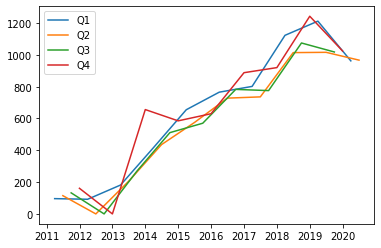

In [79]:
plt.plot(compound.xs(('Q1', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q1', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q1')
plt.plot(compound.xs(('Q2', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q2', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q2')
plt.plot(compound.xs(('Q3', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q3', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q3')
plt.plot(compound.xs(('Q4', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q4', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q4')
plt.legend()
plt.show()

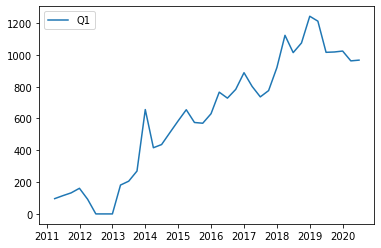

In [83]:
plt.plot(compound.xs('AR', level='Company').index.get_level_values('Date'), 
         compound.xs('AR', level='Company')['Revenue'], label='Q1')
plt.legend()
plt.show()

In [15]:
compound = compound.astype(np.float64)

In [16]:
compound.head()

Revenue  Operating Income  Consensus:  \
Date       Quarter Company                                              
2011-03-31 Q1      AMPY        0.000000          0.000000         0.0   
                   APA      3921.999872       1974.000000      3754.5   
                   AR         96.068000         25.234000         0.0   
                   BATL       26.595000          6.587000         0.0   
                   BCEI       21.436696          6.618292         0.0   

                            % Surprise | % Est. vs Consensus  \
Date       Quarter Company                                     
2011-03-31 Q1      AMPY                             0.000000   
                   APA                              0.044613   
                   AR                               0.000000   
                   BATL                             0.000000   
                   BCEI                             0.000000   

                            Revenue Growth (YoY)  Cost of Revenue  \
Date       Quarter Company                                          
2011-03-31 Q1      AMPY                      NaN         0.000000   
                   APA                       NaN     -1836.000000   
                   AR                        NaN       -61.344000   
                   BATL                      NaN       -15.461000   
                   BCEI                      NaN       -11.001468   

                            Gross Profit  Gross margin  \
Date       Quarter Company                               
2011-03-31 Q1      AMPY         0.000000      0.000000   
                   APA       2085.999872      0.531871   
                   AR          34.724000      0.361452   
                   BATL        11.134000      0.418650   
                   BCEI        10.435228      0.486793   

                            Other Operating Income  Operating Expenses  ...  \
Date       Quarter Company                                              ...   
2011-03-31 Q1      AMPY                        0.0            0.000000  ...   
                   APA                         0.0         -112.000000  ...   
                   AR                          0.0           -9.490000  ...   
                   BATL                        0.0           -4.547000  ...   
                   BCEI                        0.0           -3.816937  ...   

                            EBITDA / Interest  EBITDA - CAPEX / Interest  \
Date       Quarter Company                                                 
2011-03-31 Q1      AMPY                   NaN                        NaN   
                   APA                    NaN                        NaN   
                   AR                     NaN                        NaN   
                   BATL                   NaN                        NaN   
                   BCEI                   NaN                        NaN   

                            CAPEX / REVENUE  CAPEX / EBITDA  FCF / DEBT  \
Date       Quarter Company                                                
2011-03-31 Q1      AMPY                 NaN             NaN         NaN   
                   APA                  NaN             NaN         NaN   
                   AR                   NaN             NaN         NaN   
                   BATL                 NaN             NaN         NaN   
                   BCEI                 NaN             NaN         NaN   

                            Gross Leverage (Total Debt / EBITDA)  \
Date       Quarter Company                                         
2011-03-31 Q1      AMPY                                      NaN   
                   APA                                       NaN   
                   AR                                        NaN   
                   BATL                                      NaN   
                   BCEI                                      NaN   

                            Net Leverage (Net Debt / EBITDA)  \
Date       Quarter Company

Находим признаки, которые являются коррелированными для всех компаний

In [17]:
to_drop = set()
for item in companies:
    X = compound.xs(item, level='Company')
    corr_matrix = X.corr().abs()
    # select upper traingle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop_cur = set([column for column in upper.columns if any(upper[column] > 0.85)])
    to_drop = to_drop & to_drop_cur if len(to_drop)!= 0 else to_drop_cur
to_drop = list(to_drop)

to_drop - коррелированные признаки

In [18]:
to_drop

['Ending Equity',
 'NPAT',
 'Lease Adj Total Capital',
 'EBIT',
 'Cash & Equivalents',
 'Total Debt',
 'Total Capital',
 'Capex',
 'Net Debt',
 'Total Equity',
 'Lease Adj EBIT',
 'Total Long-Term Assets',
 'Total Debt + PV of OL',
 'Revenue (LTM)',
 'Total Liabilities',
 'Total Assets',
 'Total Liabilities & Equity',
 'Cash and Marketable Securities',
 'Net Income Avail to Common, Adj']

Далее удаляем эти признаки из compound

In [19]:
compound.drop(columns=to_drop, inplace=True)

Пример тепловой карты для матрицы корреляций между признаками для компании AMPY

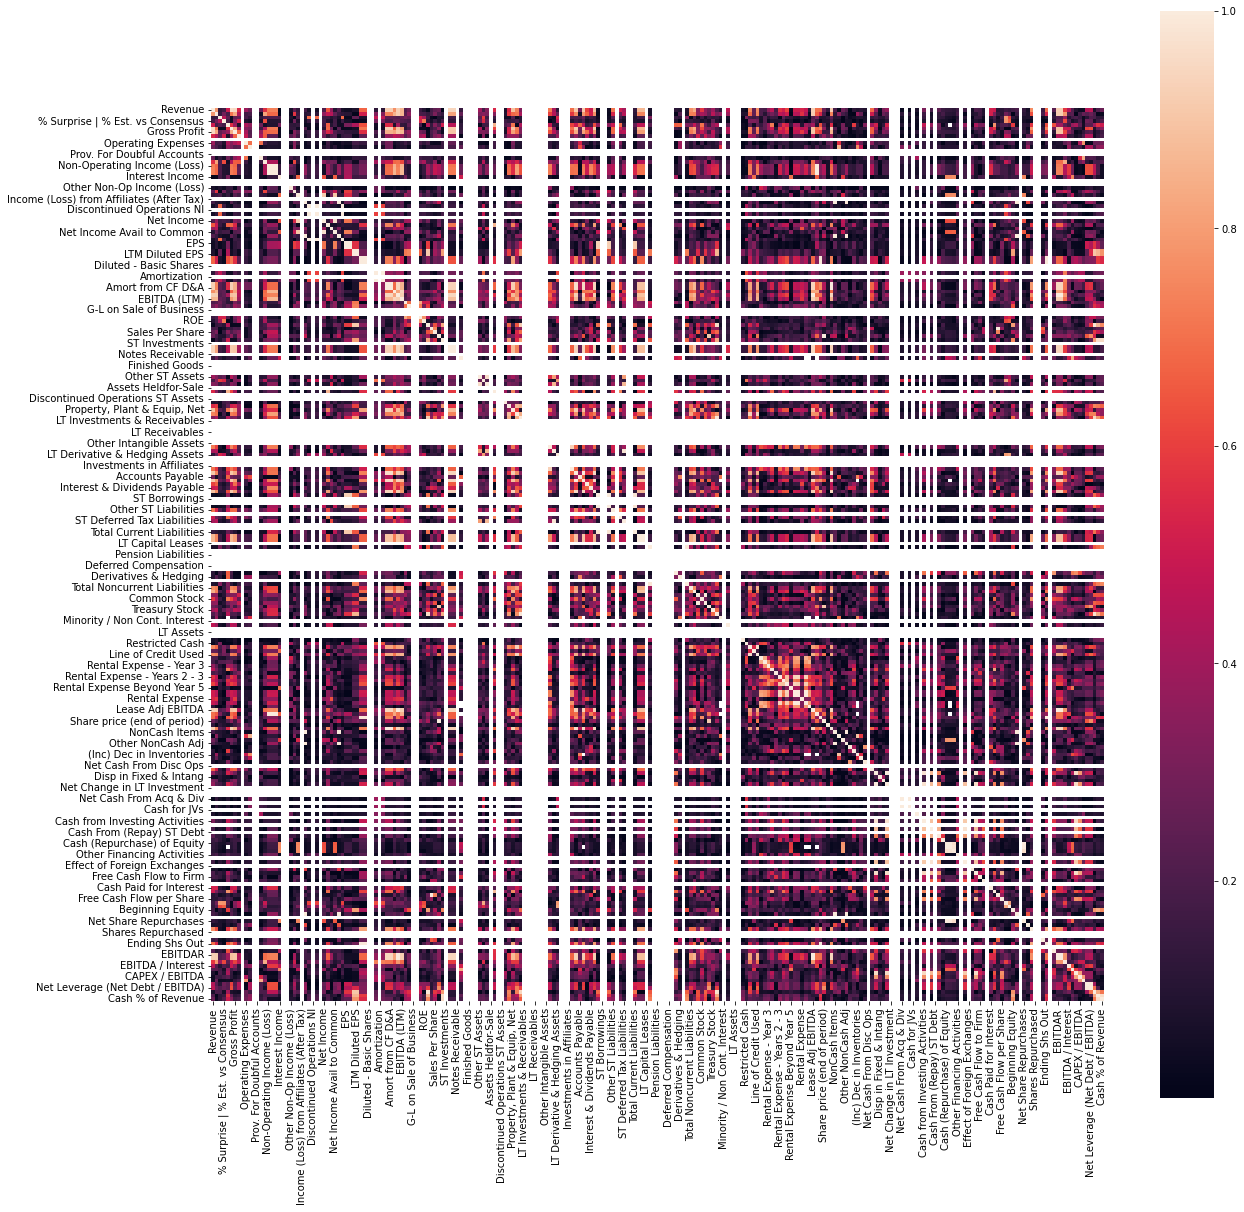

In [28]:
smth = compound.xs('AMPY', level='Company')
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(smth.corr().abs(), square = True, ax=ax)
 
plt.show()

Интерактивный график Revenue от времени по компаниям

In [20]:
fig = go.Figure()

for item in companies:
    fig.add_trace(
        go.Scatter(
            x = compound.xs(item, level='Company').index.get_level_values('Date'),
            y = compound.xs(item, level='Company')['Revenue'],
            name = item
        )
    )
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = item,
                  method = 'update',
                  args = [{'visible': [i==item for i in companies]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Revenue',
                           'showlegend':True}]) for item in companies])
        )
    ])

fig.show()

Интерактивный график Operating Income от времени по компаниям

In [21]:
fig = go.Figure()

for item in companies:
    fig.add_trace(
        go.Scatter(
            x = compound.xs(item, level='Company').index.get_level_values('Date'),
            y = compound.xs(item, level='Company')['Operating Income'],
            name = item
        )
    )
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = item,
                  method = 'update',
                  args = [{'visible': [i==item for i in companies]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Operating Income',
                           'showlegend':True}]) for item in companies])
        )
    ])

fig.show()

Рисуем heatmap для матрицы корреляций Revenue между всеми компаниями

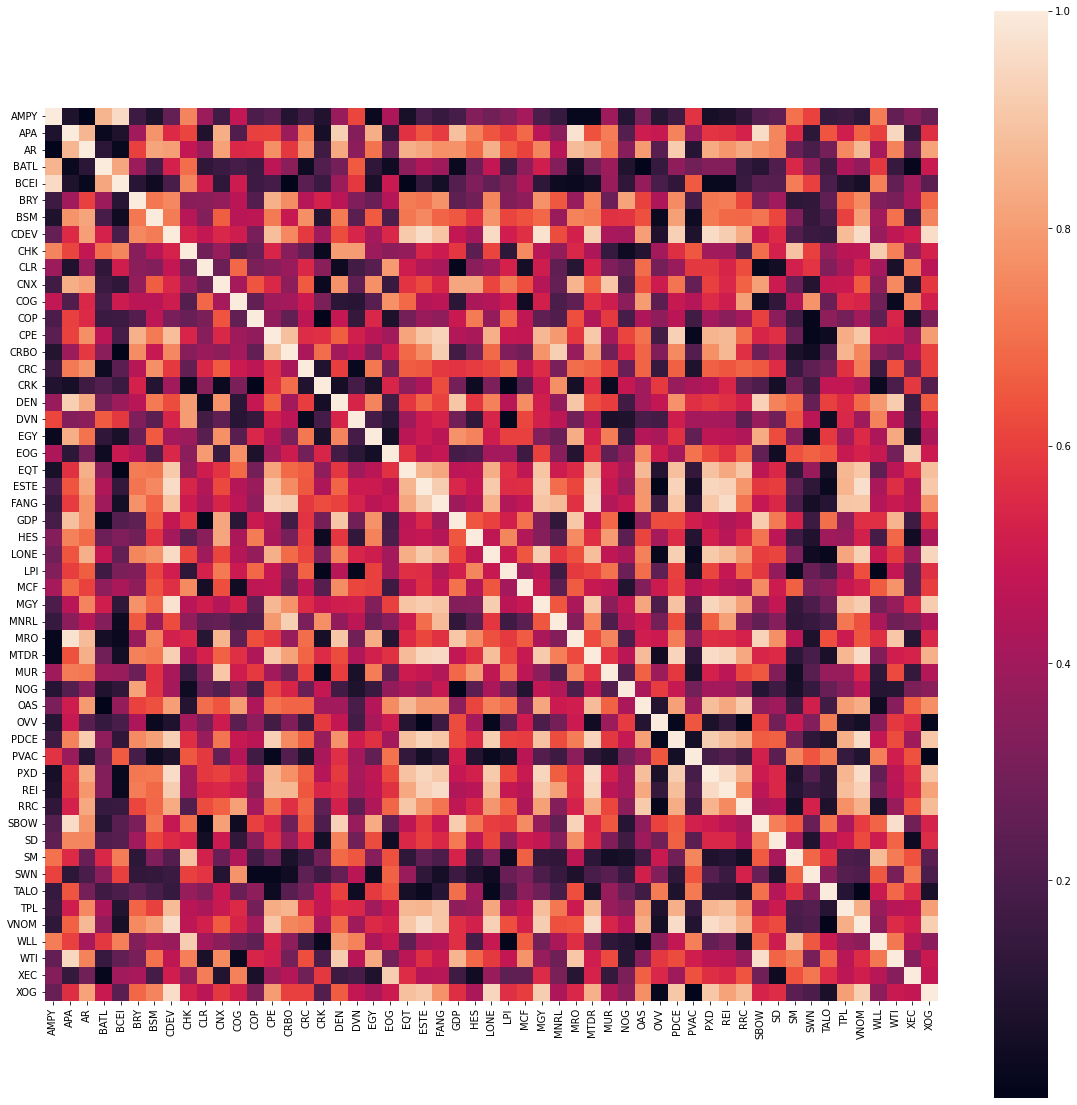

In [26]:
revenues = pd.DataFrame()
for item in companies:
    revenues[item] = compound.xs(item, level='Company')['Revenue']
    
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(revenues.corr().abs(), square = True, ax=ax)

plt.show()

То же самое для Operating Income

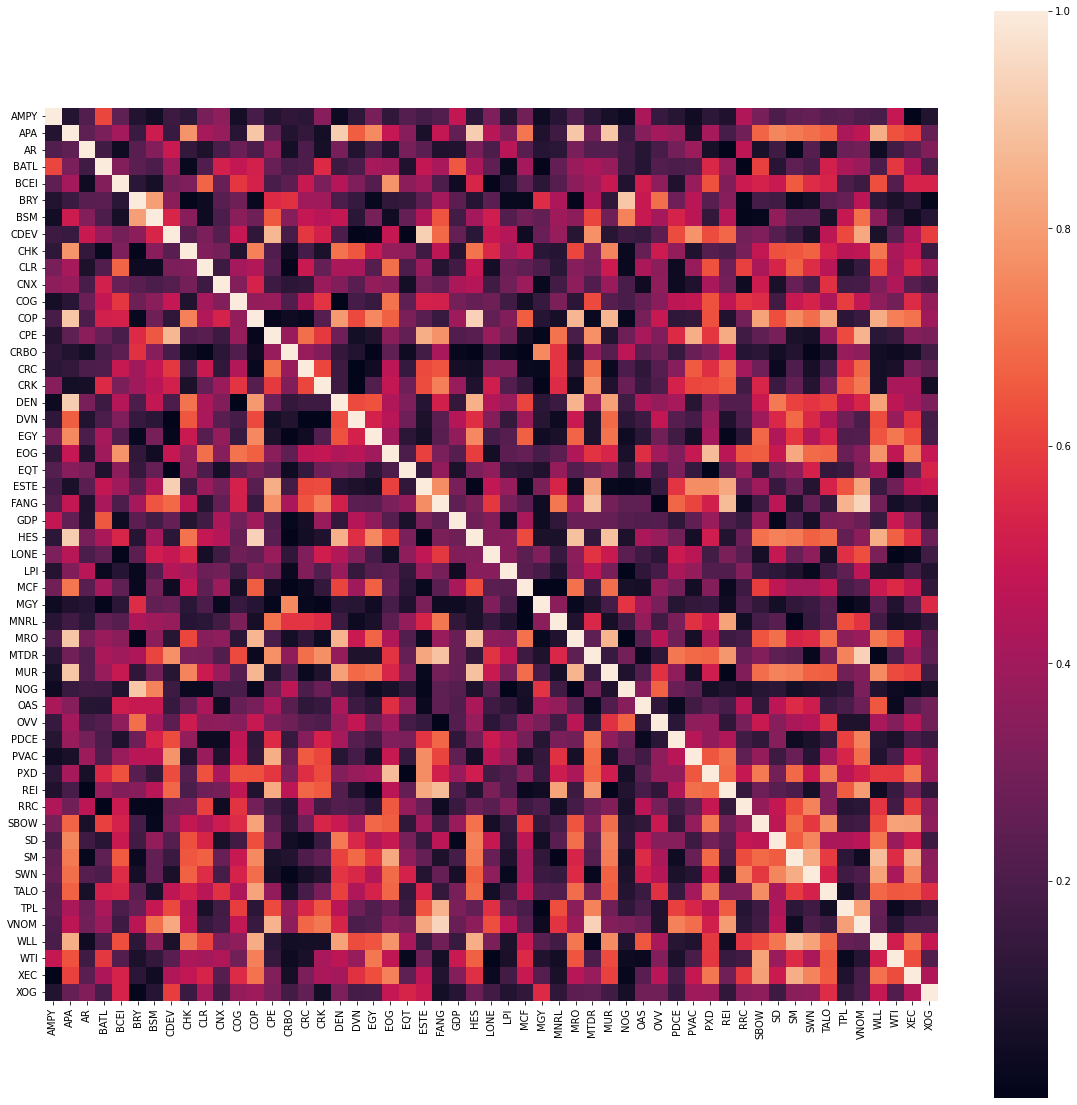

In [27]:
revenues = pd.DataFrame()
for item in companies:
    revenues[item] = compound.xs(item, level='Company')['Operating Income']
    
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(revenues.corr().abs(), square = True, ax=ax)

plt.show()

На первый взгляд кажется, что карта матрицы корреляций для Operating Income в целом темнее, чем матрица для Revenue, что может означать, что выручка гораздо больше коррелирована для разных компаний по сравнению с Operating Income

In [30]:
pip install pandasgui

ERROR: Could not find a version that satisfies the requirement pandasgui (from versions: none)
ERROR: No matching distribution found for pandasgui
Note: you may need to restart the kernel to use updated packages.


In [29]:
from pandasgui import show

show(compound)

ModuleNotFoundError: No module named 'pandasgui'